In [1]:
import torch 
from torch import nn
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
data=pd.read_csv(r"C:\Users\Avijit\Desktop\AgriAssure\AGRIYIELDPRO\PROCESSED_DATASET\yield5.csv")

In [3]:
x1=data.iloc[:,:-1]
y1=data.iloc[:,-1:]

In [4]:
yscaler=StandardScaler()


In [5]:
Yscale=yscaler.fit_transform(y1)

In [6]:
x=torch.tensor(x1.values,dtype=torch.float)
y=torch.tensor(Yscale,dtype=torch.float)

In [39]:
class yieldpredicionModelv1(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int ):
        super().__init__()
        self.regressor=nn.Sequential(
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.PReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.PReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.PReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self,x):
        return self.regressor(x)

In [40]:
torch.manual_seed(42)
# model=yieldpredicionModelv1(input_shape=5,hidden_units=128,output_shape=1).to(device='cuda')
device='cuda' if torch.cuda.is_available() else 'cpu'
model=yieldpredicionModelv1(input_shape=x.shape[1],hidden_units=256,output_shape=1).to(device)

In [41]:
loss_fn=torch.nn.SmoothL1Loss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)


In [42]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.8,random_state=42)

In [43]:
device='cuda'

In [44]:
def train(model, xtrain, ytrain, lossfn, optimizer, device):
    model.train()
    xtrain = xtrain.to(device)
    ytrain = ytrain.to(device)

    trainpred = model(xtrain)
    loss = lossfn(trainpred, ytrain)
    r2 = r2_score(ytrain.detach().cpu().numpy(), trainpred.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"TRAINLOSS: [{loss.item()}] TRAIN-R2SCORE: [{r2}]")
    return loss.item(), r2


def evaluate_model(model, xtest, ytest, loss_fn, device):
    model.eval()
    xtest, ytest = xtest.to(device), ytest.to(device)

    with torch.inference_mode():
        pred = model(xtest)
        loss = loss_fn(pred, ytest)
        
        y_true = ytest.detach().cpu().numpy()
        y_pred = pred.detach().cpu().numpy()
        r2 = r2_score(y_true, y_pred)
    print(f"TESTLOSS: [{loss.item()}] TEST-R2SCORE: [{r2}]")
    return loss.item(), r2


In [45]:
epochs=30000
patience = 1000
best_loss = float('inf')
counter = 0
best_model_state = None
early_stop = False
train_loss,train_r2,test_loss,test_r2=[],[],[],[]

for epoch in range(epochs):
    print(f"EPOCH-->{epoch}")
    trainloss,trainr2 = train(model, xtrain, ytrain, loss_fn, optimizer, device)
    train_loss.append(trainloss)
    train_r2.append(trainr2)
    testloss, testr2 = evaluate_model(model, xtest, ytest, loss_fn, device)
    test_loss.append(testloss)
    test_r2.append(testr2)

    if testloss < best_loss:
        print(f"Validation loss improved from {best_loss:.4f} to {testloss:.4f}")
        best_loss = testloss
        best_model_state = model.state_dict()
        counter = 0 
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            early_stop = True
            break

if early_stop:
    model.load_state_dict(best_model_state)


EPOCH-->0
TRAINLOSS: [0.4242419898509979] TRAIN-R2SCORE: [-0.001156449317932129]
TESTLOSS: [0.4187728762626648] TEST-R2SCORE: [0.011910021305084229]
Validation loss improved from inf to 0.4188
EPOCH-->1
TRAINLOSS: [0.4157510995864868] TRAIN-R2SCORE: [0.008925437927246094]
TESTLOSS: [0.41306421160697937] TEST-R2SCORE: [0.017457008361816406]
Validation loss improved from 0.4188 to 0.4131
EPOCH-->2
TRAINLOSS: [0.4092843234539032] TRAIN-R2SCORE: [0.009313523769378662]
TESTLOSS: [0.41239798069000244] TEST-R2SCORE: [0.010239183902740479]
Validation loss improved from 0.4131 to 0.4124
EPOCH-->3
TRAINLOSS: [0.4067908823490143] TRAIN-R2SCORE: [-0.015877485275268555]
TESTLOSS: [0.4131857752799988] TEST-R2SCORE: [0.004149138927459717]
EPOCH-->4
TRAINLOSS: [0.40671607851982117] TRAIN-R2SCORE: [-0.01922774314880371]
TESTLOSS: [0.409858763217926] TEST-R2SCORE: [0.01795172691345215]
Validation loss improved from 0.4124 to 0.4099
EPOCH-->5
TRAINLOSS: [0.4043881893157959] TRAIN-R2SCORE: [-0.00441467761

In [ ]:
train_loss

[0.4242419898509979,
 0.4157510995864868,
 0.4092843234539032,
 0.4067908823490143,
 0.40671607851982117,
 0.4043881893157959,
 0.4005539119243622,
 0.39979231357574463,
 0.3997158706188202,
 0.39738890528678894,
 0.3958546817302704,
 0.3952206075191498,
 0.3950757682323456,
 0.3945011794567108,
 0.3960907459259033,
 0.3938140273094177,
 0.39152875542640686,
 0.39080390334129333,
 0.391048401594162,
 0.38994845747947693,
 0.3893384337425232,
 0.38789668679237366,
 0.38780391216278076,
 0.38642367720603943,
 0.3851960301399231,
 0.3851526081562042,
 0.3832149803638458,
 0.38270115852355957,
 0.38170063495635986,
 0.38052114844322205,
 0.3813421130180359,
 0.37837842106819153,
 0.37725239992141724,
 0.3768426477909088,
 0.37722116708755493,
 0.3758174479007721,
 0.3748762905597687,
 0.37449517846107483,
 0.3726447820663452,
 0.3706039786338806,
 0.37043681740760803,
 0.36979976296424866,
 0.3695303201675415,
 0.36837056279182434,
 0.3682880401611328,
 0.36997318267822266,
 0.370583385229

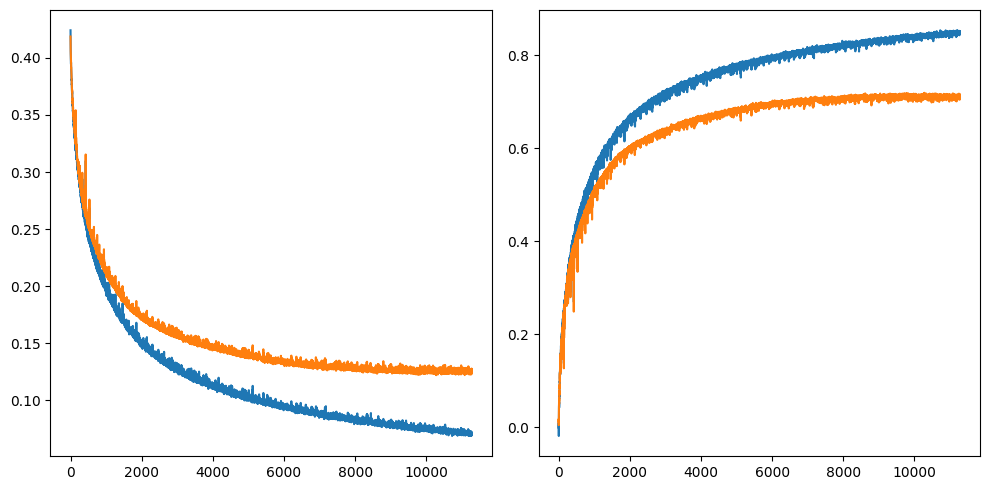

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss)
plt.plot(test_loss)
plt.subplot(1,2,2)
plt.plot(train_r2)
plt.plot(test_r2)
plt.tight_layout()
plt.show()

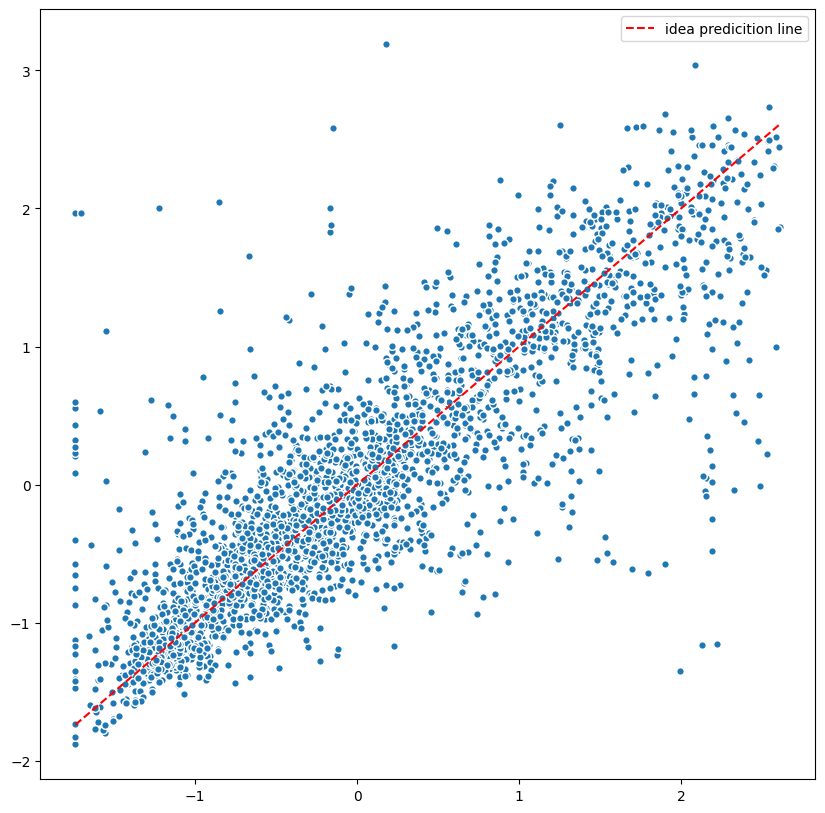

In [84]:
testpred=model(xtest.to(device))
plt.figure(figsize=(10,10))
plt.scatter(
    ytest.detach().cpu().numpy(),testpred.detach().cpu().numpy(),s=30,edgecolors='white'
)
ymin=ytest.min().item()
ymax=ytest.max().item()
plt.plot([ymin,ymax],[ymin,ymax],'r--',label='idea predicition line')
plt.legend()
plt.show()